<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_06_04_survival_analysis_competing_risks_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 6.4  Competing Risks of Joint Models


In survival analysis, **competing risks** arise when individuals face multiple possible event types, and the occurrence of one event precludes the others. For instance, in a study of disease-specific death, deaths from other causes (such as accidents or unrelated illnesses) act as competing risks. In the context of **joint models**, competing risks analysis involves modeling the time to multiple event types while accounting for their correlation with longitudinal biomarkers. These joint models combine: (1) a **longitudinal submodel** for the repeated measurements of a continuous outcome over time, and (2) a **competing risks survival submodel** for the multiple event types. The two submodels are connected via **shared random effects**, which capture the association between the longitudinal trajectory and the risk of each event type.

To fit such a model in **`{JMbayes2}`**, the first step is to restructure the event data into a **long format** suitable for competing risks. Specifically, if there are $K$ event types, each subject must be represented by $K$ rows—one for each cause. The observed event time $T_i$ is repeated across these rows, accompanied by two indicator variables: one specifying the event cause and another indicating whether that cause actually occurred. Standard survival datasets (with one row per subject) can be converted to this format using the `crisk_setup()` function, which takes the original survival data, the name of the status variable, and the value denoting censoring.


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316570 sha256=a1fc0b101755ea02079ef6bbe4762bf5b88b7bbfc61ecd30d9f2073b16017027
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  Competing Risks of Joint Models in R


We use the `pbc2` dataset from the `{JMbayes2}` package, which contains longitudinal measurements and survival data for patients with primary biliary cirrhosis (PBC). In this example, we will model the longitudinal biomarker `serBilir` (serum bilirubin levels) and the competing risks of death due to PBC and death due to other causes.



### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [3]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'condSURV',
		 'riskRegression',
		 'prodlim',
		 'lava',
		 'mstate',
		 'regplot',
		 'cmprskcoxmsm',
		 'GLMMadaptive',
		 'nlme',
		 'lme4',
		 'lattice',
		 'JM',
		 'joineR',
		 'joineRML',
		 'JMbayes2'
		 )


### Install missing packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')


### Verify Installation

In [4]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom

  method         from 
  augment.mjoint broom
  glance.mjoint  broom
  tidy.mjoint    broom



     tidyverse       survival      survminer      ggsurvfit     tidycmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggfortify        timereg         cmprsk       condSURV riskRegression 
          TRUE           TRUE           TRUE           TRUE           TRUE 
       prodlim           lava         mstate        regplot   cmprskcoxmsm 
          TRUE           TRUE           TRUE           TRUE           TRUE 
  GLMMadaptive           nlme           lme4        lattice             JM 
          TRUE           TRUE           TRUE           TRUE           TRUE 
        joineR       joineRML       JMbayes2 
          TRUE           TRUE           TRUE 


### Load Packages

In [5]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [6]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:JMbayes2"       "package:joineRML"       "package:joineR"        
 [4] "package:JM"             "package:splines"        "package:MASS"          
 [7] "package:lattice"        "package:lme4"           "package:Matrix"        
[10] "package:nlme"           "package:GLMMadaptive"   "package:cmprskcoxmsm"  
[13] "package:regplot"        "package:mstate"         "package:lava"          
[16] "package:prodlim"        "package:riskRegression" "package:condSURV"      
[19] "package:cmprsk"         "package:timereg"        "package:ggfortify"     
[22] "package:tidycmprsk"     "package:ggsurvfit"      "package:survminer"     
[25] "package:ggpubr"         "package:survival"       "package:lubridate"     
[28] "package:forcats"        "package:stringr"        "package:dplyr"         
[31] "package:purrr"          "package:readr"          "package:tidyr"         
[34] "package:tibble"         "package:ggplot2"        "package:tidyverse"     
[37] "pack

### Load data


We use `pbc2` dataset from the `JMbayes2` package, which contains follow up of 312 randomized patients with primary biliary cirrhosis, a rare autoimmune liver disease, at Mayo Clinic.


In [7]:
%%R
data(pbc2)
data(pbc2.id)

### Prepare Data for Competing Risks


We convert the `pbc2.id` dataset into a long format suitable for competing risks analysis using the `crisk_setup()` function. The `status` variable indicates the event type, with "alive" representing censoring.


In [8]:
%%R
pbc2.id[pbc2.id$id %in% c(1, 2, 5), c("id", "years", "status")]

pbc2.idCR <- crisk_setup(pbc2.id, statusVar = "status", censLevel = "alive",
                         nameStrata = "CR")

pbc2.idCR[pbc2.idCR$id %in% c(1, 2, 5),
          c("id", "years", "status", "status2", "CR")]

    id     years       status status2           CR
1    1  1.095170         dead       1         dead
1.1  1  1.095170         dead       0 transplanted
2    2 14.152338        alive       0         dead
2.1  2 14.152338        alive       0 transplanted
5    5  4.120578 transplanted       0         dead
5.1  5  4.120578 transplanted       1 transplanted


### Fit the Joint Model with Competing Risks

#### Fit Cause-Specific Cox Models


Firs, t we fit the corresponding cause-specific Cox regressions by including the interaction terms of age and treatment with variable CR, which is treated as a stratification variable using the strata() function:


In [9]:
%%R
CoxFit_CR <- coxph(Surv(years, status2) ~ (age + drug) * strata(CR),
                     data = pbc2.idCR)

#### Fit the Longitudinal Submodel


Next, we fit two longitudinal submodels for the biomarker `serBilir` using a linear mixed-effects model:



In [10]:
%%R
fm1 <- lme(log(serBilir) ~ poly(year, 2) * drug, data = pbc2,
           random = ~ poly(year, 2) | id)
fm2 <- lme(prothrombin ~ year * drug, data = pbc2, random = ~ year | id)

#### Specify the Association Structure


To specify the association structure between the longitudinal and survival submodels, we define a list of formulas indicating how each longitudinal outcome is linked to the competing risks. In this example, we use the current value of `log(serBilir)` and `prothrombin` to model their effects on the hazard of each event type:


In [11]:
%%R
CR_forms <- list(
    "log(serBilir)" = ~ value(log(serBilir)):CR,
    "prothrombin" = ~ value(prothrombin):CR
)

#### Fit Risk Joint Model


Finally, we fit the joint model for competing risks using the `jm()` function, specifying the cause-specific Cox model, the list of longitudinal submodels, the time variable, and the functional forms for the association structure. We also set the number of iterations, burn-in period, and thinning interval for the MCMC sampling:


In [12]:
%%R
jFit_CR <- jm(CoxFit_CR, list(fm1, fm2), time_var = "year",
              functional_forms = CR_forms,
              n_iter = 25000L, n_burnin = 5000L, n_thin = 5L)

summary(jFit_CR)



Call:
jm(Surv_object = CoxFit_CR, Mixed_objects = list(fm1, fm2), time_var = "year", 
    functional_forms = CR_forms, n_iter = 25000L, n_burnin = 5000L, 
    n_thin = 5L)

Data Descriptives:
Number of Groups: 312		Number of events: 169 (27.1%)
Number of Observations:
  log(serBilir): 1945
  prothrombin: 1945

                 DIC     WAIC     LPML
marginal    10843.93 11610.66 -6774.89
conditional 15749.96 15437.45 -8238.58

Random-effects covariance matrix:
                                             
       StdDev    Corr                        
(Intr) 1.3447  (Intr)  p(,2)1  p(,2)2  (Intr)
p(,2)1 23.1131 0.7078                        
p(,2)2 12.4801 -0.2555 -0.1397               
(Intr) 0.7854  0.6327  0.4356  -0.3325       
year   0.3266  0.4334  0.3398  -0.0517 0.0330

Survival Outcome:
                                       Mean  StDev    2.5%   97.5%      P
age                                 -0.0711 0.0243 -0.1201 -0.0234 0.0030
drugD-penicil                       -0.2703 0.

### Dynamic Predictions


We can obtain dynamic predictions for a specific patient (e.g., patient with `id` 81) using their longitudinal data and event information. We create a list containing the longitudinal data and event data for this patient, setting the `status2` variable to 0 to indicate censoring:



In [13]:
%%R
ND_long <- pbc2[pbc2$id == 81, ]
ND_event <- pbc2.idCR[pbc2.idCR$id == 81, ]
ND_event$status2 <- 0
ND <- list(newdataL = ND_long, newdataE = ND_event)

#### Predict Longitudinal and Event Outcomes

In [14]:
%%R
predLong <- predict(jFit_CR, newdata = ND, return_newdata = TRUE,
                    times = seq(6.5, 15, length = 25))

predEvent <- predict(jFit_CR, newdata = ND, return_newdata = TRUE,
                     process = "event")

#### Plot Dynamic Predictions

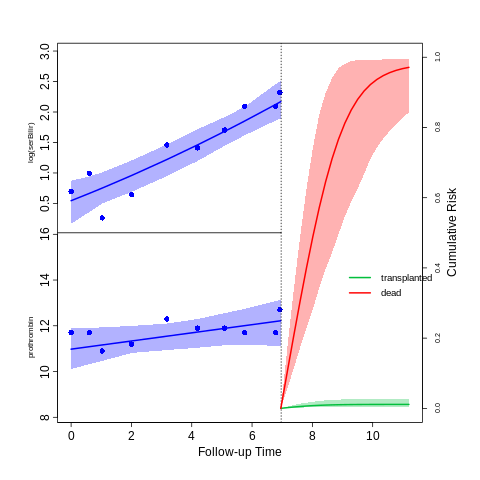

In [15]:
%%R
plot(predLong, predEvent, outcomes = 1:2, ylim_long_outcome_range = FALSE,
     col_line_event = c("#03BF3D", "#FF0000"),
     fill_CI_event = c("#03BF3D4D", "#FF00004D"), pos_ylab_long = c(1.5, 11.5))
legend(x = 8.1, y = 0.45, legend = levels(pbc2.idCR$CR),
       lty = 1, lwd = 2, col = c("#03BF3D", "#FF0000"), bty = "n", cex = 0.8)

## Summary and Conclusion


In this notebook, we explored the application of joint models for competing risks using the `{JMbayes2}` package in R. We demonstrated how to prepare the data for competing risks analysis, fit cause-specific Cox models, and specify the association structure between longitudinal biomarkers and competing event types. Finally, we illustrated how to obtain dynamic predictions for individual patients based on their longitudinal data and event history. Joint models for competing risks provide a powerful framework for understanding the complex relationships between longitudinal processes and multiple event types in survival analysis.


## Resources


1. Rizopoulos, D. (2012). *Joint Models for Longitudinal and Time-to-Event Data: With Applications in R*. Chapman and Hall/CRC.

2.  Rizopoulos, D. (2024). *JMbayes2: Joint Models for Longitudinal and Time-to-Event Data under a Bayesian Approach*. R package version 0.9.6. https://CRAN.R-project.org/package=JMbayes2

3.  [Competing Risks](https://drizopoulos.github.io/JMbayes2/articles/Competing_Risks.html)